In [196]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from pathlib import Path

Configuration

In [197]:
excel_path = r"Z:\UriMons\Modulation_Index\Photometry&Behavior\Grooming&photometry.xlsx"   # <-- set your path
sheet_name = "Sheet1"

# metrics present in your sheet
all_metrics = ["GroomingTime", "GroomingBouts", "TimePerBout", "AUC", "Events", "Amplitude"]

# fixed stage order (10 stages)
stage_order = ["BL1","BL2","Stress1","Stress2","PS1","PS2","PS3","PS4","PS5","PS6"]

# general photometry & grooming index: 
general_photometry_metrics = ["AUC","Events"] # use AUC & Events only (exclude Amplitude)
general_grooming_metrics = ["GroomingTime", "GroomingBouts"] # exclude TimePerBout 

# plotting colors
colors = {"WT":"blue", "KO":"red"}

# small epsilon for safe division
EPS = 1e-12

Helpers

In [198]:
def normalize_stage(s):
    s = str(s).strip().upper().replace("-", "").replace("_","")
    # Map common variants to canonical names
    if s.startswith("BL1"):  return "BL1"
    if s.startswith("BL2"):  return "BL2"
    if s.startswith("STRESS1"): return "Stress1"
    if s.startswith("STRESS2"): return "Stress2"
    if s.startswith("PS1"):   return "PS1"
    if s.startswith("PS2"):   return "PS2"
    if s.startswith("PS3"):   return "PS3"
    if s.startswith("PS4"):   return "PS4"
    if s.startswith("PS5"):   return "PS5"
    if s.startswith("PS6"):   return "PS6"
    # tolerant fallbacks
    if s.startswith("BL"):    return "BL1"   # treat unknown BLx as BL1
    if s.startswith("STRESS"):return "Stress1"
    if s.startswith("PS"):    return "PS1"
    return "BL1"

def symmetric_mi(stage_val, bl1_val, eps=EPS):
    # (Stage - BL1)/(Stage + BL1)
    return (stage_val - bl1_val) / (stage_val + bl1_val + eps)

def mean_sem_by_genotype(df, value_col):
    g = df.groupby("Genotype")[value_col]
    out = g.agg(n="count", mean="mean", std="std").reset_index()
    out["sem"] = out["std"] / np.sqrt(out["n"])
    return out

def welch_t_wt_vs_ko(df, value_col):
    wt = df.loc[df["Genotype"]=="WT", value_col].dropna()
    ko = df.loc[df["Genotype"]=="KO", value_col].dropna()
    if len(wt)>=2 and len(ko)>=2:
        t, p = stats.ttest_ind(wt, ko, equal_var=False, nan_policy="omit")
    else:
        t, p = np.nan, np.nan
    return t, p

def p_to_stars(p):
    if pd.isna(p): return "ns"
    if p < 1e-4: return "****"
    if p < 1e-3: return "***"
    if p < 1e-2: return "**"
    if p < 5e-2: return "*"
    return "ns"

def grouped_bar(ax, summary_df, x_labels, title, ylim=None, zero_line=True, pad_frac=0.08):
    """
    Draw grouped bars (WT/KO) for each x_label (Stage or Metric).
    Auto-scales y-axis from data unless ylim is provided.
    summary_df must have columns: [label_col already selected in caller], 'Genotype', 'mean', 'sem'
    """
    order = ["WT","KO"]
    x = np.arange(len(x_labels))
    width = 0.38

    # draw bars
    for i, g in enumerate(order):
        subset = summary_df[summary_df["Genotype"]==g]
        means = [subset.loc[subset.iloc[:,0]==lab, "mean"].values[0] if lab in subset.iloc[:,0].values else np.nan
                 for lab in x_labels]
        sems  = [subset.loc[subset.iloc[:,0]==lab, "sem"].values[0]  if lab in subset.iloc[:,0].values else np.nan
                 for lab in x_labels]
        ax.bar(x + (i-0.5)*width, means, width,
               yerr=sems, capsize=5, edgecolor="black",
               color=colors.get(g, None), alpha=0.9, label=g)

    if zero_line:
        ax.axhline(0, color="black", linewidth=1)

    ax.set_xticks(x, x_labels, rotation=45)
    ax.set_title(title)
    ax.set_ylabel("MI")
    ax.legend(frameon=False)
    ax.grid(axis="y", linestyle=":", alpha=0.3)

    # ---- auto y-limits if not provided ----
    if ylim is None:
        # collect all means±sem for rows used in this panel
        used = summary_df[summary_df.iloc[:,0].isin(x_labels)]
        y_low  = (used["mean"] - used["sem"]).min(skipna=True)
        y_high = (used["mean"] + used["sem"]).max(skipna=True)
        if zero_line:
            y_low  = np.nanmin([y_low, 0])
            y_high = np.nanmax([y_high, 0])
        # ensure non-degenerate range
        if pd.isna(y_low) or pd.isna(y_high) or y_low == y_high:
            y_low, y_high = -0.1, 0.1
        pad = (y_high - y_low) * pad_frac
        ax.set_ylim(y_low - pad, y_high + pad)
    else:
        ax.set_ylim(*ylim)


def add_sig_stars_over_stage(ax, panel_df, stage_labels, ylim_pad=0.05):
    """
    panel_df: summary_table slice for a single metric with columns Stage, Genotype, mean, sem, p_value
    stage_labels: list of stage labels in plotting order
    """
    for xi, lab in enumerate(stage_labels):
        sub = panel_df[panel_df["Stage"] == lab]
        if sub.empty:
            continue
        pvals = sub["p_value"].dropna().unique()
        if len(pvals) == 0:
            continue
        p = float(pvals[0])
        if p >= 0.05:
            continue  # skip non-significant
        # star placement
        stars = p_to_stars(p)
        ymax = (sub["mean"] + sub["sem"]).max()
        ax.text(xi, ymax + ylim_pad, stars, ha="center", va="bottom",
                fontsize=12, fontweight="bold")

def compute_ylim_from_panel(panel_df, zero_line=True, floor_at_zero=False):
    """
    panel_df needs columns: ['mean','sem'] (optionally others).
    Returns (ymin, ymax) with a 10% headroom.
    - zero_line=True   -> include 0 in the visible range if helpful.
    - floor_at_zero=True -> never go below 0 (useful for |MI| panels).
    """
    if panel_df.empty:
        return (-1, 1)

    vals_min = (panel_df["mean"] - panel_df["sem"]).min()
    vals_max = (panel_df["mean"] + panel_df["sem"]).max()

    # If asked to floor at 0 (absolute MI panels)
    if floor_at_zero:
        vals_min = max(0.0, float(vals_min))

    ymin, ymax = float(vals_min), float(vals_max)

    # If zero_line requested, make sure 0 is included
    if zero_line:
        ymin = min(0.0, ymin)
        ymax = max(0.0, ymax)

    # Add 10% padding
    span = ymax - ymin
    if span == 0:
        span = 1.0  # avoid zero-span
        ymin, ymax = ymin - 0.5, ymax + 0.5
    else:
        pad = 0.10 * span
        ymin -= pad
        ymax += pad

    return (ymin, ymax)


def add_sig_stars(ax, panel_df, label_col, labels, ybounds=None, pad_frac=0.03):
    """
    Draw significance stars for WT vs KO for each label (Stage or Metric).
    panel_df must have: [label_col, 'Genotype', 'mean', 'sem', 'p_value'].
    ybounds: the y-limits you set on the axes; if None we grab current limits.
    pad_frac: fraction of y-range to place the stars above the tallest bar.
    """
    if ybounds is None:
        ybounds = ax.get_ylim()
    yspan = ybounds[1] - ybounds[0]
    pad = pad_frac * yspan

    for xi, lab in enumerate(labels):
        sub = panel_df[panel_df[label_col] == lab]
        if sub.empty:
            continue
        pvals = sub["p_value"].dropna().unique()
        if len(pvals) == 0:
            continue
        p = float(pvals[0])
        # Your p->stars function
        stars = p_to_stars(p)
        if stars == "ns":
            continue
        ymax_bar = (sub["mean"] + sub["sem"]).max()
        ax.text(xi, ymax_bar + pad, stars, ha="center", va="bottom",
                fontsize=12, fontweight="bold")


Load data

In [199]:
df = pd.read_excel(excel_path, sheet_name=sheet_name)
df["Genotype"] = df["Genotype"].astype(str).str.strip().str.upper()
df["Stage"] = df["Stage"].apply(normalize_stage)

# keep only known stages, ordered
df = df[df["Stage"].isin(stage_order)].copy()
df["Stage"] = pd.Categorical(df["Stage"], categories=stage_order, ordered=True)

PER-MOUSE MI FOR EVERY STAGE VS BL1

In [200]:
per_mouse_rows = []

for metric in all_metrics:
    # wide per mouse
    w = df.pivot_table(index=["Mouse","Genotype"], columns="Stage", values=metric, aggfunc="mean")
    # ensure all stages present
    for s in stage_order:
        if s not in w.columns:
            w[s] = np.nan
    # reference = BL1
    bl1 = w["BL2"]

    # compute MI for every stage vs BL1 (skip BL1 itself)
    for s in stage_order:
        if s == "BL2": 
            continue
        mi_vals = symmetric_mi(w[s], bl1)
        per_mouse_rows.append(pd.DataFrame({
            "Mouse": w.index.get_level_values("Mouse"),
            "Genotype": w.index.get_level_values("Genotype"),
            "Metric": metric,
            "Stage": s,
            "MI": mi_vals
        }))

# tidy per-mouse / per-stage MI
mi_long = pd.concat(per_mouse_rows, ignore_index=True)


COMBINED ACROSS STAGES (mean absolute MI across all stages except BL1)

In [201]:
combined_stage_rows = []
for metric in all_metrics:
    sub = mi_long[mi_long["Metric"]==metric]
    combo = (sub.assign(absMI=sub["MI"].abs())
                .groupby(["Mouse","Genotype","Metric"], as_index=False)["absMI"].mean()
                .rename(columns={"absMI":"MI"}))
    combo["Stage"] = "AllStages_AbsMean_vsBL1"
    combined_stage_rows.append(combo)

mi_long = pd.concat([mi_long] + combined_stage_rows, ignore_index=True)


GENERAL PHOTOMETRY MI
(AUC & Events only, exclude Amplitude)
1) Per-stage: mean(|MI_AUC|, |MI_Events|) vs BL1
2) Overall: mean of those per-stage values across all stages except BL1

In [202]:
# per-stage
photometry_stage_rows = []
for s in stage_order:
    if s == "BL1": 
        continue
    # grab AUC & Events MI for this stage
    two = mi_long[(mi_long["Stage"]==s) & (mi_long["Metric"].isin(general_photometry_metrics))].copy()
    if two.empty: 
        continue
    agg = (two.assign(absMI=two["MI"].abs())
               .groupby(["Mouse","Genotype"], as_index=False)["absMI"].mean()
               .rename(columns={"absMI":"MI"}))
    agg["Metric"] = "GeneralPhotometry"
    agg["Stage"] = s
    photometry_stage_rows.append(agg)

general_photo_stage = pd.concat(photometry_stage_rows, ignore_index=True) if photometry_stage_rows else pd.DataFrame(
    columns=["Mouse","Genotype","MI","Metric","Stage"]
)

# overall (across all stages except BL1)
if not general_photo_stage.empty:
    overall_gp = (general_photo_stage
                  .groupby(["Mouse","Genotype"], as_index=False)["MI"].mean()
                  .assign(Metric="GeneralPhotometry", Stage="AllStages_AbsMean_vsBL1")
                  .rename(columns={"MI":"MI"}))
    # append to mi_long
    mi_long = pd.concat([mi_long, general_photo_stage, overall_gp], ignore_index=True)


General Grooming MI (per-stage)

In [203]:
gg_stage_rows = []
for s in stages_x:  # all stages except the baseline reference
    sel = mi_long[(mi_long["Stage"]==s) & (mi_long["Metric"].isin(general_grooming_metrics))].copy()
    if sel.empty:
        continue
    # per mouse: mean absolute MI across grooming metrics for this stage
    agg = (sel.assign(absMI=sel["MI"].abs())
              .groupby(["Mouse","Genotype"], as_index=False)["absMI"].mean()
              .rename(columns={"absMI":"MI"}))
    agg["Metric"] = "GeneralGrooming"
    agg["Stage"] = s
    gg_stage_rows.append(agg)

general_grooming_stage = (pd.concat(gg_stage_rows, ignore_index=True)
                          if gg_stage_rows else
                          pd.DataFrame(columns=["Mouse","Genotype","MI","Metric","Stage"]))

# --- General Grooming MI (overall across stages) ---
if not general_grooming_stage.empty:
    general_grooming_overall = (general_grooming_stage
                                .groupby(["Mouse","Genotype"], as_index=False)["MI"].mean()
                                .assign(Metric="GeneralGrooming", Stage="AllStages_AbsMean_vsBL1"))
    # append to mi_long for completeness
    mi_long = pd.concat([mi_long, general_grooming_stage, general_grooming_overall], ignore_index=True)

    # summarize & test, then append to summary_table
    # per-stage summaries
    gg_summ_rows = []
    for s in list(general_grooming_stage["Stage"].unique()) + ["AllStages_AbsMean_vsBL1"]:
        sub = mi_long[(mi_long["Metric"]=="GeneralGrooming") & (mi_long["Stage"]==s)]
        if sub.empty: 
            continue
        gsum = sub.groupby("Genotype")["MI"].agg(n="count", mean="mean", std="std").reset_index()
        gsum["sem"] = gsum["std"] / np.sqrt(gsum["n"])
        # Welch t
        wt = sub.loc[sub["Genotype"]=="WT","MI"].dropna()
        ko = sub.loc[sub["Genotype"]=="KO","MI"].dropna()
        if len(wt)>=2 and len(ko)>=2:
            t, p = stats.ttest_ind(wt, ko, equal_var=False, nan_policy="omit")
        else:
            t, p = np.nan, np.nan
        gsum["Metric"] = "GeneralGrooming"
        gsum["Stage"] = s
        gsum["p_value"] = p
        gg_summ_rows.append(gsum)

    gg_summary = pd.concat(gg_summ_rows, ignore_index=True)
    summary_table = pd.concat([summary_table, gg_summary], ignore_index=True)

    # add stars/significance cols again (since we appended rows)
    summary_table["sig"] = summary_table["p_value"].apply(p_to_stars)
    summary_table["is_significant"] = summary_table["p_value"] < 0.05

    # re-save summary CSV
    summary_table.to_csv(summary_csv, index=False)


SAVE PER-MOUSE CSV

In [204]:
out_dir = Path(excel_path).resolve().parent
mi_per_mouse_csv = out_dir / "EPA_MI_per_mouse_tidy.csv"
mi_long.to_csv(mi_per_mouse_csv, index=False)


SUMMARY BY GENOTYPE + WELCH TESTS

In [205]:
summary_rows = []
test_rows = []

for metric in sorted(mi_long["Metric"].unique()):
    for stage in sorted(mi_long[mi_long["Metric"]==metric]["Stage"].unique(),
                        key=lambda s: (stage_order + ["AllStages_AbsMean_vsBL1"]).index(s) 
                                      if s in stage_order + ["AllStages_AbsMean_vsBL1"] else 999):
        sub = mi_long[(mi_long["Metric"]==metric) & (mi_long["Stage"]==stage)]
        if sub.empty: 
            continue
        summ = mean_sem_by_genotype(sub, "MI")
        t, p = welch_t_wt_vs_ko(sub, "MI")
        summ["Metric"] = metric
        summ["Stage"] = stage
        summ["p_value"] = p
        summary_rows.append(summ)
        test_rows.append({"Metric":metric, "Stage":stage, "t_stat":t, "p_value":p})

summary_table = pd.concat(summary_rows, ignore_index=True)[
    ["Metric","Stage","Genotype","n","mean","sem","std","p_value"]
]

summary_table["sig"] = summary_table["p_value"].apply(p_to_stars)
summary_table["is_significant"] = summary_table["p_value"] < 0.05

summary_csv = out_dir / "EPA_MI_summary_by_genotype.csv"
summary_table.to_csv(summary_csv, index=False)

# pretty print
disp = summary_table.copy()
disp["mean±SEM"] = disp["mean"].round(3).astype(str) + " ± " + disp["sem"].round(3).astype(str)
print("\n=== WT vs KO summaries (Welch p-values) ===")
print(disp[["Metric","Stage","Genotype","n","mean±SEM","p_value","sig"]]
      .sort_values(["Metric","Stage","Genotype"]).to_string(index=False))



=== WT vs KO summaries (Welch p-values) ===
           Metric                   Stage Genotype  n       mean±SEM  p_value sig
              AUC AllStages_AbsMean_vsBL1       KO  8  0.167 ± 0.017 0.112097  ns
              AUC AllStages_AbsMean_vsBL1       WT  5  0.267 ± 0.049 0.112097  ns
              AUC                     BL1       KO  8  0.138 ± 0.036 0.229633  ns
              AUC                     BL1       WT  5  0.213 ± 0.045 0.229633  ns
              AUC                     PS1       KO  8 -0.086 ± 0.086 0.515827  ns
              AUC                     PS1       WT  5  0.012 ± 0.115 0.515827  ns
              AUC                     PS2       KO  8 -0.049 ± 0.039 0.163122  ns
              AUC                     PS2       WT  5   0.192 ± 0.14 0.163122  ns
              AUC                     PS3       KO  8  -0.071 ± 0.07 0.072929  ns
              AUC                     PS3       WT  5  0.188 ± 0.103 0.072929  ns
              AUC                     PS4       KO  8

PLOTTING (INLINE)

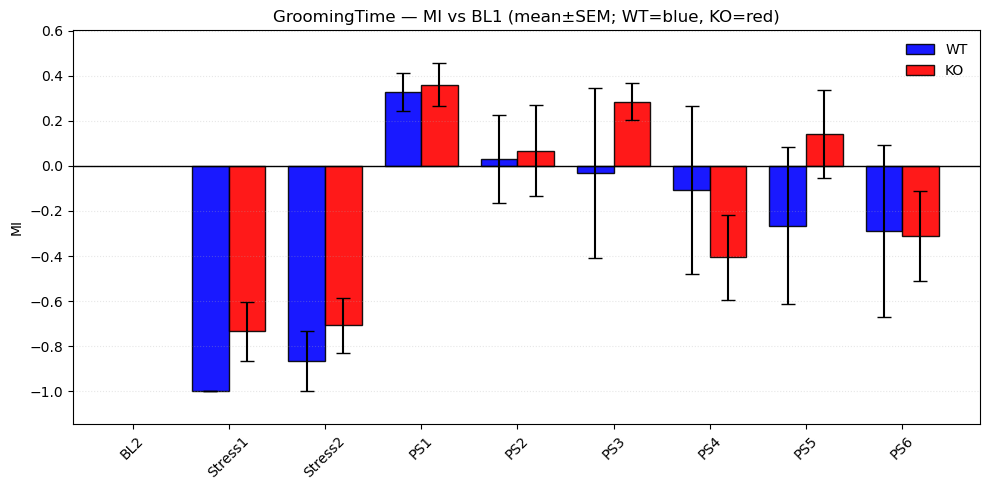

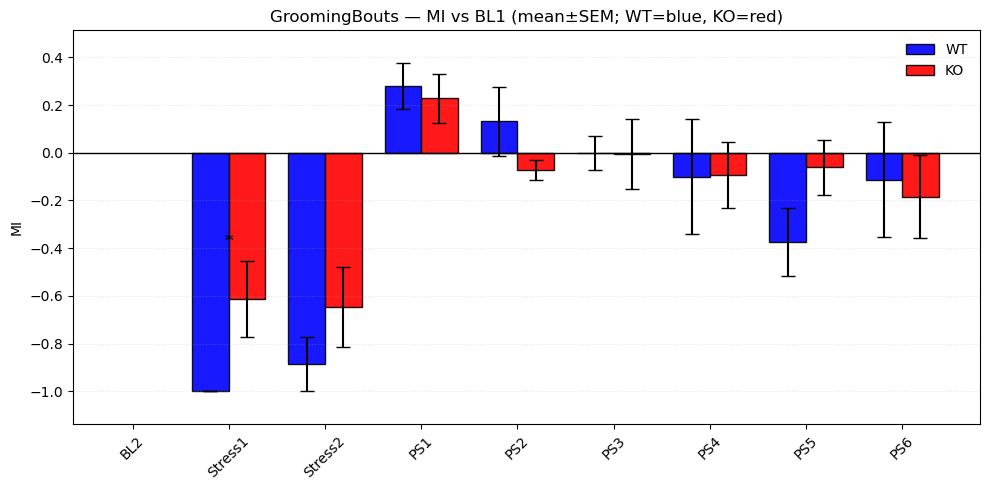

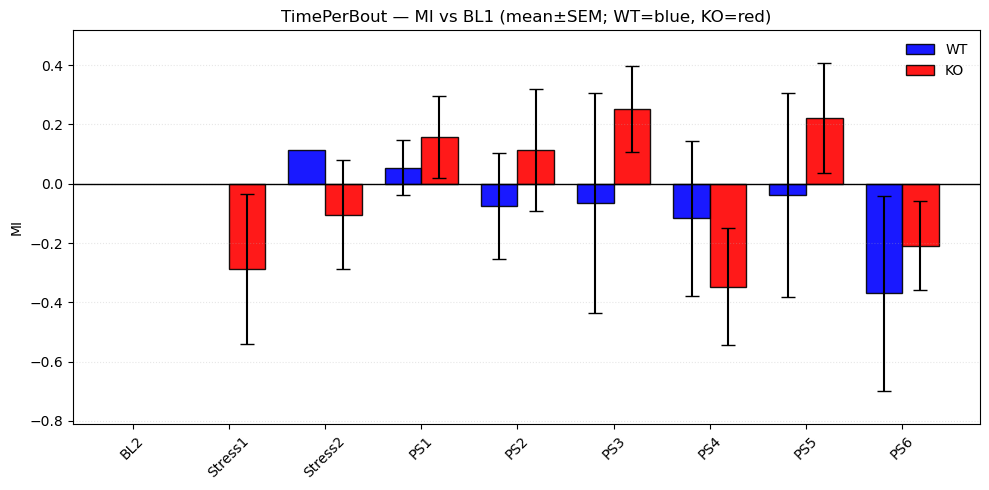

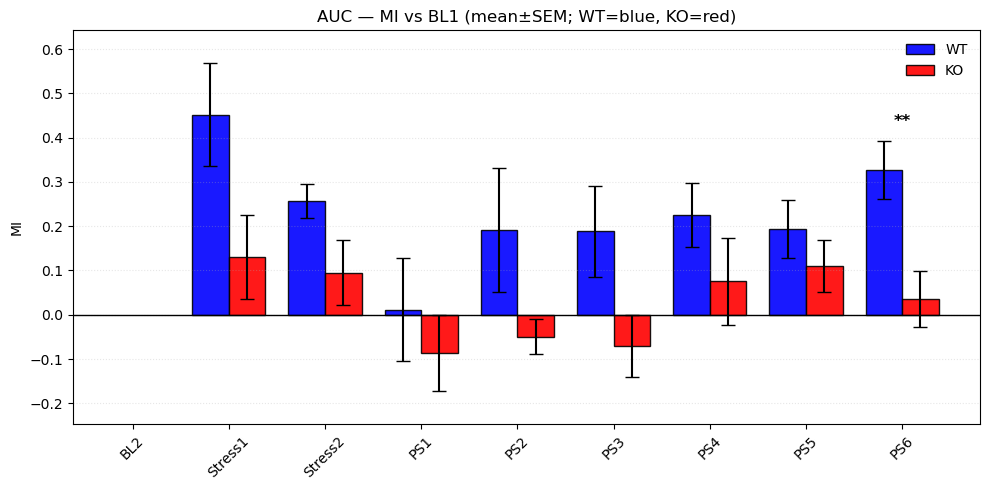

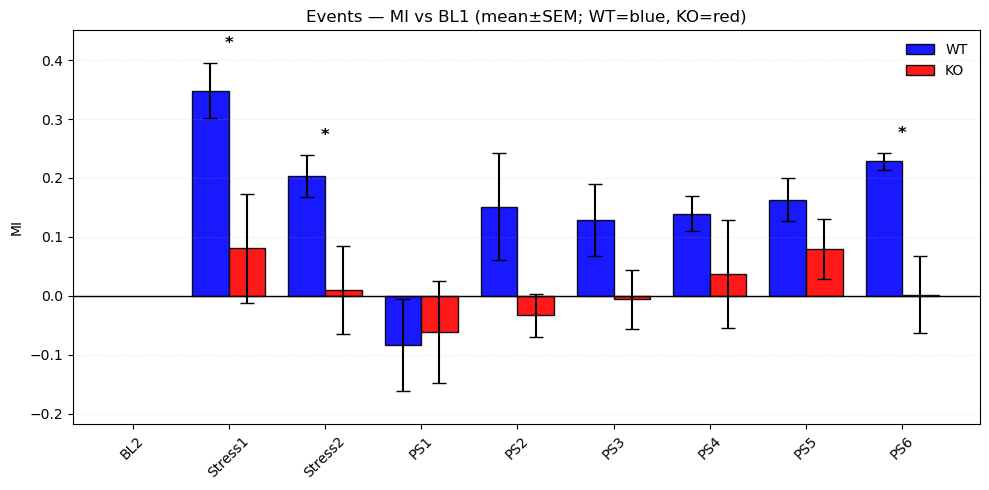

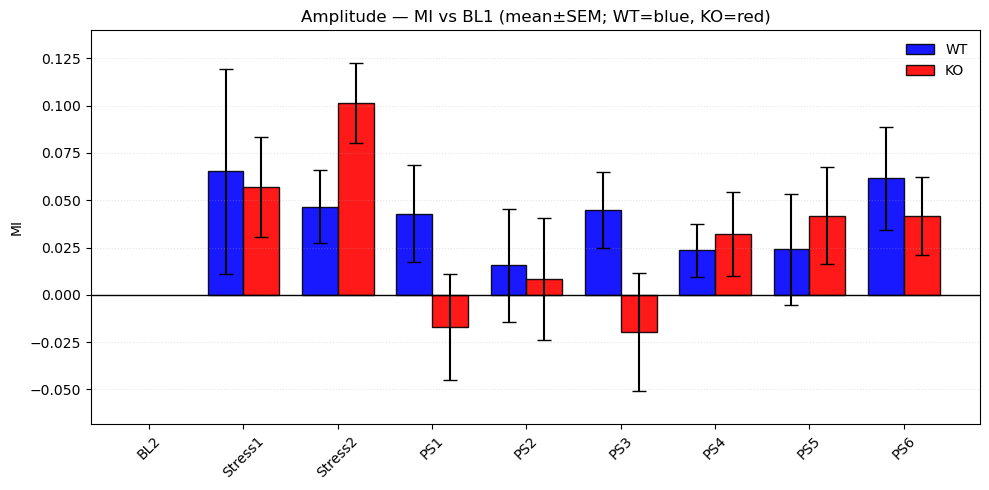

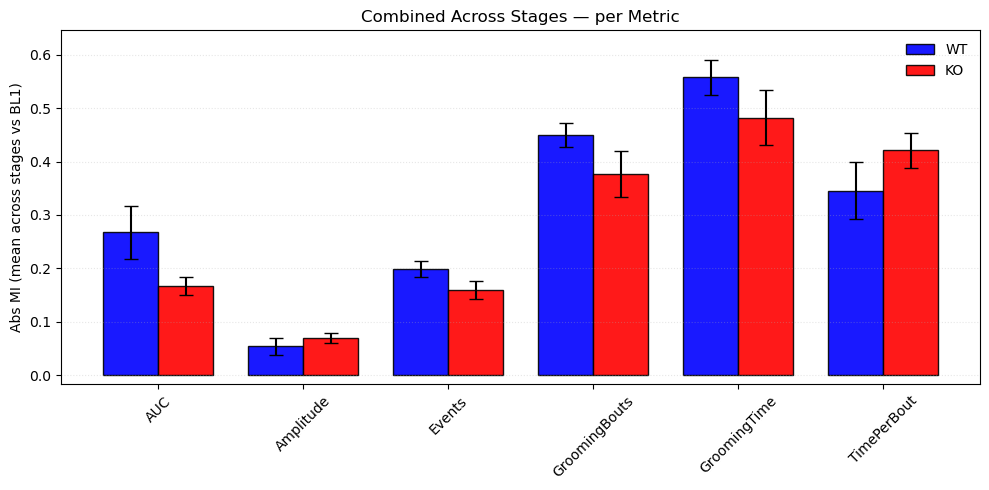

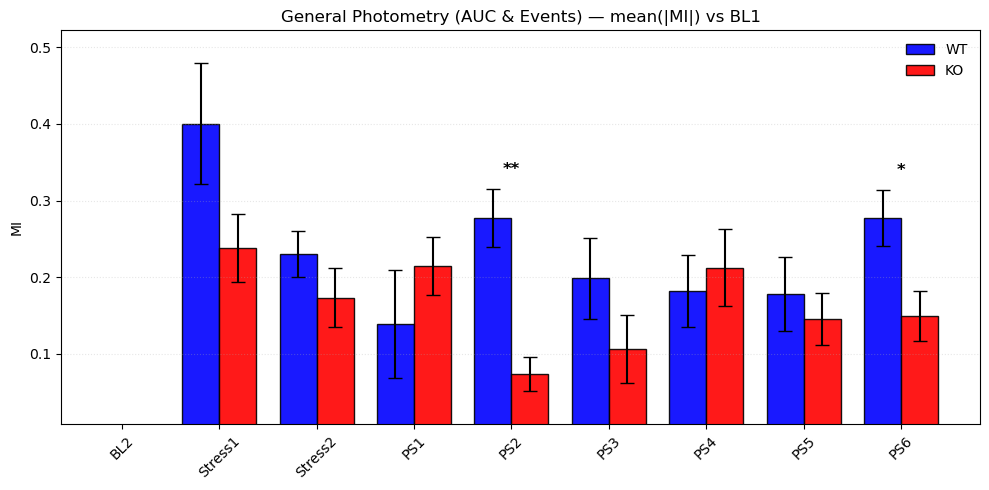

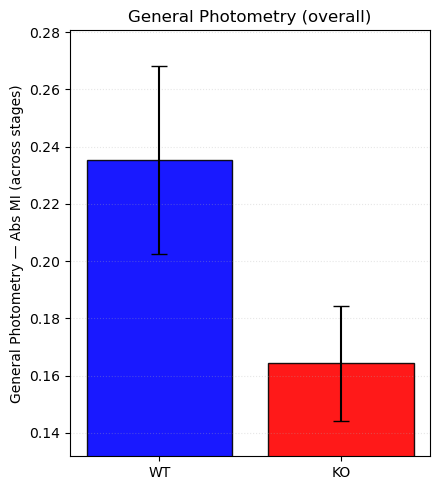

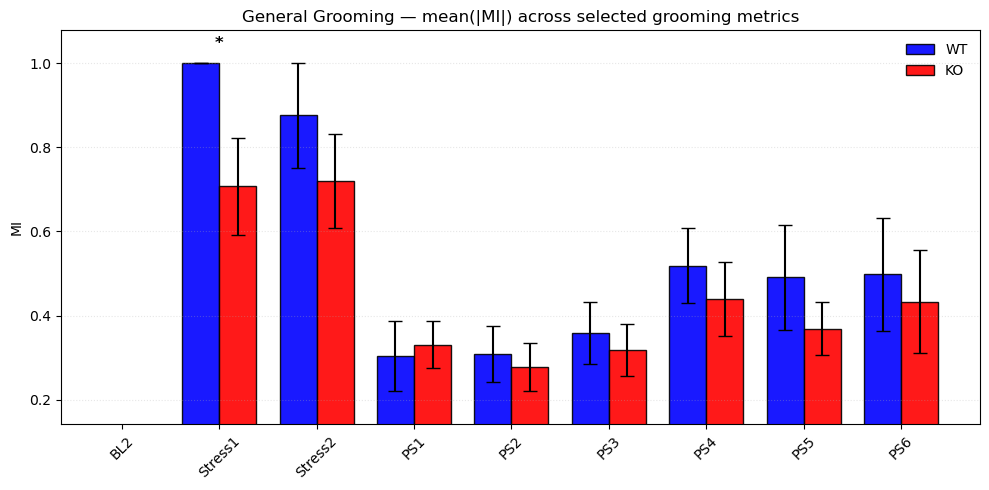

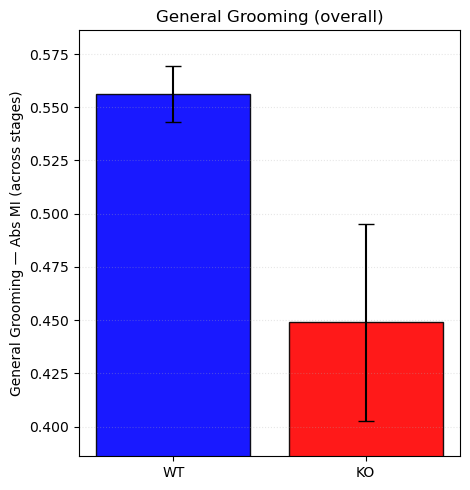

In [206]:
# 1) Per-metric grouped bar: stages on x-axis, WT vs KO bars
stages_x = [s for s in stage_order if s != "BL1"]  # or BL2 if that’s your reference

for metric in all_metrics:
    panel = summary_table[(summary_table["Metric"]==metric) & (summary_table["Stage"].isin(stages_x))]
    if panel.empty:
        continue
    fig, ax = plt.subplots(figsize=(10,5))

    # draw bars (your grouped_bar is fine; it doesn’t set ylim itself)
    grouped_bar(ax, panel[["Stage","Genotype","mean","sem"]], stages_x,
                title=f"{metric} — MI vs BL1 (mean±SEM; WT=blue, KO=red)",
                zero_line=True)

    # dynamic y-limits from actual data
    ybounds = compute_ylim_from_panel(panel, zero_line=True, floor_at_zero=False)
    ax.set_ylim(*ybounds)

    # stars with proportional padding
    add_sig_stars(ax, panel[["Stage","Genotype","mean","sem","p_value"]],
                  label_col="Stage", labels=stages_x, ybounds=ybounds, pad_frac=0.03)

    plt.tight_layout()
    plt.show()


# 2) Combined across stages (per metric)
panel_combined = summary_table[
    (summary_table["Stage"] == "AllStages_AbsMean_vsBL1") &
    (summary_table["Metric"].isin(all_metrics))
]
if not panel_combined.empty:
    fig, ax = plt.subplots(figsize=(10,5))

    x_labels = list(panel_combined["Metric"].unique())
    x = np.arange(len(x_labels))
    width = 0.38
    for i, g in enumerate(["WT","KO"]):
        means = [panel_combined[(panel_combined["Metric"]==m) & (panel_combined["Genotype"]==g)]["mean"].values[0]
                 if not panel_combined[(panel_combined["Metric"]==m) & (panel_combined["Genotype"]==g)].empty else np.nan
                 for m in x_labels]
        sems = [panel_combined[(panel_combined["Metric"]==m) & (panel_combined["Genotype"]==g)]["sem"].values[0]
                 if not panel_combined[(panel_combined["Metric"]==m) & (panel_combined["Genotype"]==g)].empty else np.nan
                 for m in x_labels]
        ax.bar(x + (i-0.5)*width, means, width, yerr=sems, capsize=5,
               color=colors[g], edgecolor="black", alpha=0.9, label=g)

    ax.set_xticks(x, x_labels, rotation=45)
    ax.set_ylabel("Abs MI (mean across stages vs BL1)")
    ax.set_title("Combined Across Stages — per Metric")
    ax.legend(frameon=False)
    ax.grid(axis="y", linestyle=":", alpha=0.3)

    # dynamic y-limits (absolute MIs => floor at 0; no forced zero-line)
    ybounds = compute_ylim_from_panel(panel_combined, zero_line=False, floor_at_zero=True)
    ax.set_ylim(*ybounds)

    # stars atop each metric group
    add_sig_stars(ax, panel_combined[["Metric","Genotype","mean","sem","p_value"]],
                  label_col="Metric", labels=x_labels, ybounds=ybounds, pad_frac=0.03)

    plt.tight_layout()
    plt.show()


# 3) General Photometry — per-stage and overall
gp_stage_panel = summary_table[(summary_table["Metric"]=="GeneralPhotometry") &
                               (summary_table["Stage"].isin(stages_x))]
if not gp_stage_panel.empty:
    fig, ax = plt.subplots(figsize=(10,5))
    grouped_bar(ax, gp_stage_panel[["Stage","Genotype","mean","sem"]], stages_x,
                title="General Photometry (AUC & Events) — mean(|MI|) vs BL1",
                zero_line=False)

    ybounds = compute_ylim_from_panel(gp_stage_panel, zero_line=False, floor_at_zero=True)
    ax.set_ylim(*ybounds)

    add_sig_stars(ax, gp_stage_panel[["Stage","Genotype","mean","sem","p_value"]],
                  label_col="Stage", labels=stages_x, ybounds=ybounds, pad_frac=0.03)

    plt.tight_layout()
    plt.show()

gp_overall = summary_table[(summary_table["Metric"]=="GeneralPhotometry") &
                           (summary_table["Stage"]=="AllStages_AbsMean_vsBL1")]
if not gp_overall.empty:
    fig, ax = plt.subplots(figsize=(4.5,5))
    for i, g in enumerate(["WT","KO"]):
        sub = gp_overall[gp_overall["Genotype"]==g]
        if sub.empty: continue
        ax.bar([g], sub["mean"], yerr=sub["sem"], capsize=6,
               color=colors[g], edgecolor="black", alpha=0.9)
    ax.set_ylabel("General Photometry — Abs MI (across stages)")
    ax.set_title("General Photometry (overall)")
    ax.grid(axis="y", linestyle=":", alpha=0.3)

    ybounds = compute_ylim_from_panel(gp_overall, zero_line=False, floor_at_zero=True)
    ax.set_ylim(*ybounds)

    # optional star in the middle if significant
    pvals = gp_overall["p_value"].dropna().unique()
    if len(pvals):
        stars = p_to_stars(float(pvals[0]))
        if stars != "ns":
            ymax = (gp_overall["mean"] + gp_overall["sem"]).max()
            pad = 0.03 * (ybounds[1] - ybounds[0])
            ax.text(0.5, ymax + pad, stars, ha="center", va="bottom",
                    fontsize=12, fontweight="bold", transform=ax.get_xaxis_transform(False))

    plt.tight_layout()
    plt.show()


# General Grooming — per-stage
gg_stage_panel = summary_table[(summary_table["Metric"]=="GeneralGrooming") &
                               (summary_table["Stage"].isin(stages_x))]
if not gg_stage_panel.empty:
    fig, ax = plt.subplots(figsize=(10,5))
    grouped_bar(ax, gg_stage_panel[["Stage","Genotype","mean","sem"]], stages_x,
                title="General Grooming — mean(|MI|) across selected grooming metrics",
                zero_line=False)

    ybounds = compute_ylim_from_panel(gg_stage_panel, zero_line=False, floor_at_zero=True)
    ax.set_ylim(*ybounds)

    add_sig_stars(ax, gg_stage_panel[["Stage","Genotype","mean","sem","p_value"]],
                  label_col="Stage", labels=stages_x, ybounds=ybounds, pad_frac=0.03)

    plt.tight_layout()
    plt.show()

# General Grooming — overall
gg_overall = summary_table[(summary_table["Metric"]=="GeneralGrooming") &
                           (summary_table["Stage"]=="AllStages_AbsMean_vsBL1")]
if not gg_overall.empty:
    fig, ax = plt.subplots(figsize=(4.8,5))
    for i, g in enumerate(["WT","KO"]):
        sub = gg_overall[gg_overall["Genotype"]==g]
        if sub.empty: continue
        ax.bar([g], sub["mean"], yerr=sub["sem"], capsize=6,
               color=colors[g], edgecolor="black", alpha=0.9)
    ax.set_ylabel("General Grooming — Abs MI (across stages)")
    ax.set_title("General Grooming (overall)")
    ax.grid(axis="y", linestyle=":", alpha=0.3)

    ybounds = compute_ylim_from_panel(gg_overall, zero_line=False, floor_at_zero=True)
    ax.set_ylim(*ybounds)

    pvals = gg_overall["p_value"].dropna().unique()
    if len(pvals):
        stars = p_to_stars(float(pvals[0]))
        if stars != "ns":
            ymax = (gg_overall["mean"] + gg_overall["sem"]).max()
            pad = 0.03 * (ybounds[1] - ybounds[0])
            ax.text(0.5, ymax + pad, stars, ha="center", va="bottom",
                    fontsize=12, fontweight="bold", transform=ax.get_xaxis_transform(False))

    plt.tight_layout()
    plt.show()


Print compact stats table

In [207]:
# optional: order stages nicely in the printout
stage_order_print = ["BL2","Stress1","Stress2","PS1","PS2","PS3","PS4","PS5","PS6","AllStages_AbsMean_vsBL1"]

disp = summary_table.copy()
disp["mean±SEM"] = disp["mean"].round(3).astype(str) + " ± " + disp["sem"].round(3).astype(str)
disp["Stage"] = pd.Categorical(disp["Stage"], categories=stage_order_print, ordered=True)

print("\n=== WT vs KO summaries (Welch p-values) ===")
print(disp[["Metric","Stage","Genotype","n","mean±SEM","p_value","sig"]]
      .sort_values(["Metric","Stage","Genotype"]).to_string(index=False))

print("\nSaved CSVs:")
print(f" - Per-mouse MI: {mi_per_mouse_csv}")
print(f" - Summary:      {summary_csv}")



=== WT vs KO summaries (Welch p-values) ===
           Metric                   Stage Genotype  n       mean±SEM  p_value sig
              AUC                 Stress1       KO  8  0.131 ± 0.095 0.061109  ns
              AUC                 Stress1       WT  5  0.452 ± 0.116 0.061109  ns
              AUC                 Stress2       KO  8  0.095 ± 0.074 0.081804  ns
              AUC                 Stress2       WT  5  0.258 ± 0.039 0.081804  ns
              AUC                     PS1       KO  8 -0.086 ± 0.086 0.515827  ns
              AUC                     PS1       WT  5  0.012 ± 0.115 0.515827  ns
              AUC                     PS2       KO  8 -0.049 ± 0.039 0.163122  ns
              AUC                     PS2       WT  5   0.192 ± 0.14 0.163122  ns
              AUC                     PS3       KO  8  -0.071 ± 0.07 0.072929  ns
              AUC                     PS3       WT  5  0.188 ± 0.103 0.072929  ns
              AUC                     PS4       KO  8

# CORRELATIONS: Grooming ↔ Photometry (based on MI values in mi_long)


In [208]:
from scipy.stats import pearsonr

grooming_metrics_for_corr = ["GroomingTime","GroomingBouts","TimePerBout"]
photometry_metrics_for_corr = ["AUC","Events","Amplitude"]

# stages to consider (skip baselines)
stages_eval = [s for s in stage_order if s not in ["BL1","BL2"]]

# helper for significance stars
def p_to_stars(p):
    if pd.isna(p): return "ns"
    if p < 1e-4: return "****"
    if p < 1e-3: return "***"
    if p < 1e-2: return "**"
    if p < 5e-2: return "*"
    return "ns"

def corr_pair(df, g_metric, p_metric, st_g, st_p, genotype):
    g = df[(df["Metric"]==g_metric)&(df["Stage"]==st_g)&(df["Genotype"]==genotype)][["Mouse","MI"]].rename(columns={"MI":"gMI"})
    p = df[(df["Metric"]==p_metric)&(df["Stage"]==st_p)&(df["Genotype"]==genotype)][["Mouse","MI"]].rename(columns={"MI":"pMI"})
    merged = pd.merge(g,p,on="Mouse").dropna()
    n = len(merged)
    if n>=3:
        r,pv = pearsonr(merged["gMI"], merged["pMI"])
    else:
        r,pv = np.nan,np.nan
    return {"n":n,"r":r,"p":pv,"sig":p_to_stars(pv)}


SAME-STAGE correlations & CROSS-STAGE correlations

In [209]:
# -----------------------------
# SAME-STAGE correlations (WT/KO)
# -----------------------------
same_rows = []
for geno in ["WT","KO"]:
    for gm in grooming_metrics_for_corr:
        for pm in photometry_metrics_for_corr:
            for st in stages_eval:
                out = corr_pair(mi_long, gm, pm, st, st, geno)
                same_rows.append({"Genotype":geno,"GroomingMetric":gm,"PhotometryMetric":pm,
                                  "GroomingStage":st,"PhotometryStage":st,**out})

corr_same = pd.DataFrame(same_rows)
corr_same_csv = out_dir / "EPA_correlations_same_stage_by_genotype.csv"
corr_same.to_csv(corr_same_csv,index=False)

# -----------------------------
# CROSS-STAGE correlations
#   (Stress1/2 grooming ↔ Stress1/2 photometry)
#   (PS1/2 grooming ↔ Stress1/2 photometry)
# -----------------------------
cross_specs = [("Stress1","Stress1"),("Stress1","Stress2"),
               ("Stress2","Stress1"),("Stress2","Stress2"),
               ("PS1","Stress1"),("PS1","Stress2"),
               ("PS2","Stress1"),("PS2","Stress2")]

cross_rows = []
for geno in ["WT","KO"]:
    for gm in grooming_metrics_for_corr:
        for pm in photometry_metrics_for_corr:
            for (stg,stp) in cross_specs:
                out = corr_pair(mi_long, gm, pm, stg, stp, geno)
                cross_rows.append({"Genotype":geno,"GroomingMetric":gm,"PhotometryMetric":pm,
                                   "GroomingStage":stg,"PhotometryStage":stp,**out})

corr_cross = pd.DataFrame(cross_rows)
corr_cross_csv = out_dir / "EPA_correlations_cross_stage_by_genotype.csv"
corr_cross.to_csv(corr_cross_csv,index=False)

print(f"\nSaved correlation CSVs:\n - {corr_same_csv}\n - {corr_cross_csv}")


c:\Users\urimons.WISMAIN\AppData\Local\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4847: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(stats.NearConstantInputWarning(msg))
c:\Users\urimons.WISMAIN\AppData\Local\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4847: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(stats.NearConstantInputWarning(msg))
c:\Users\urimons.WISMAIN\AppData\Local\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4847: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(stats.NearConstantInputWarning(msg))
c:\Users\urimons.WISMAIN\AppData\Local\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4847: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient 


Saved correlation CSVs:
 - \\isi.storwis.weizmann.ac.il\labs\yizharlab\UriMons\Modulation_Index\Photometry&Behavior\EPA_correlations_same_stage_by_genotype.csv
 - \\isi.storwis.weizmann.ac.il\labs\yizharlab\UriMons\Modulation_Index\Photometry&Behavior\EPA_correlations_cross_stage_by_genotype.csv


PLOTTING

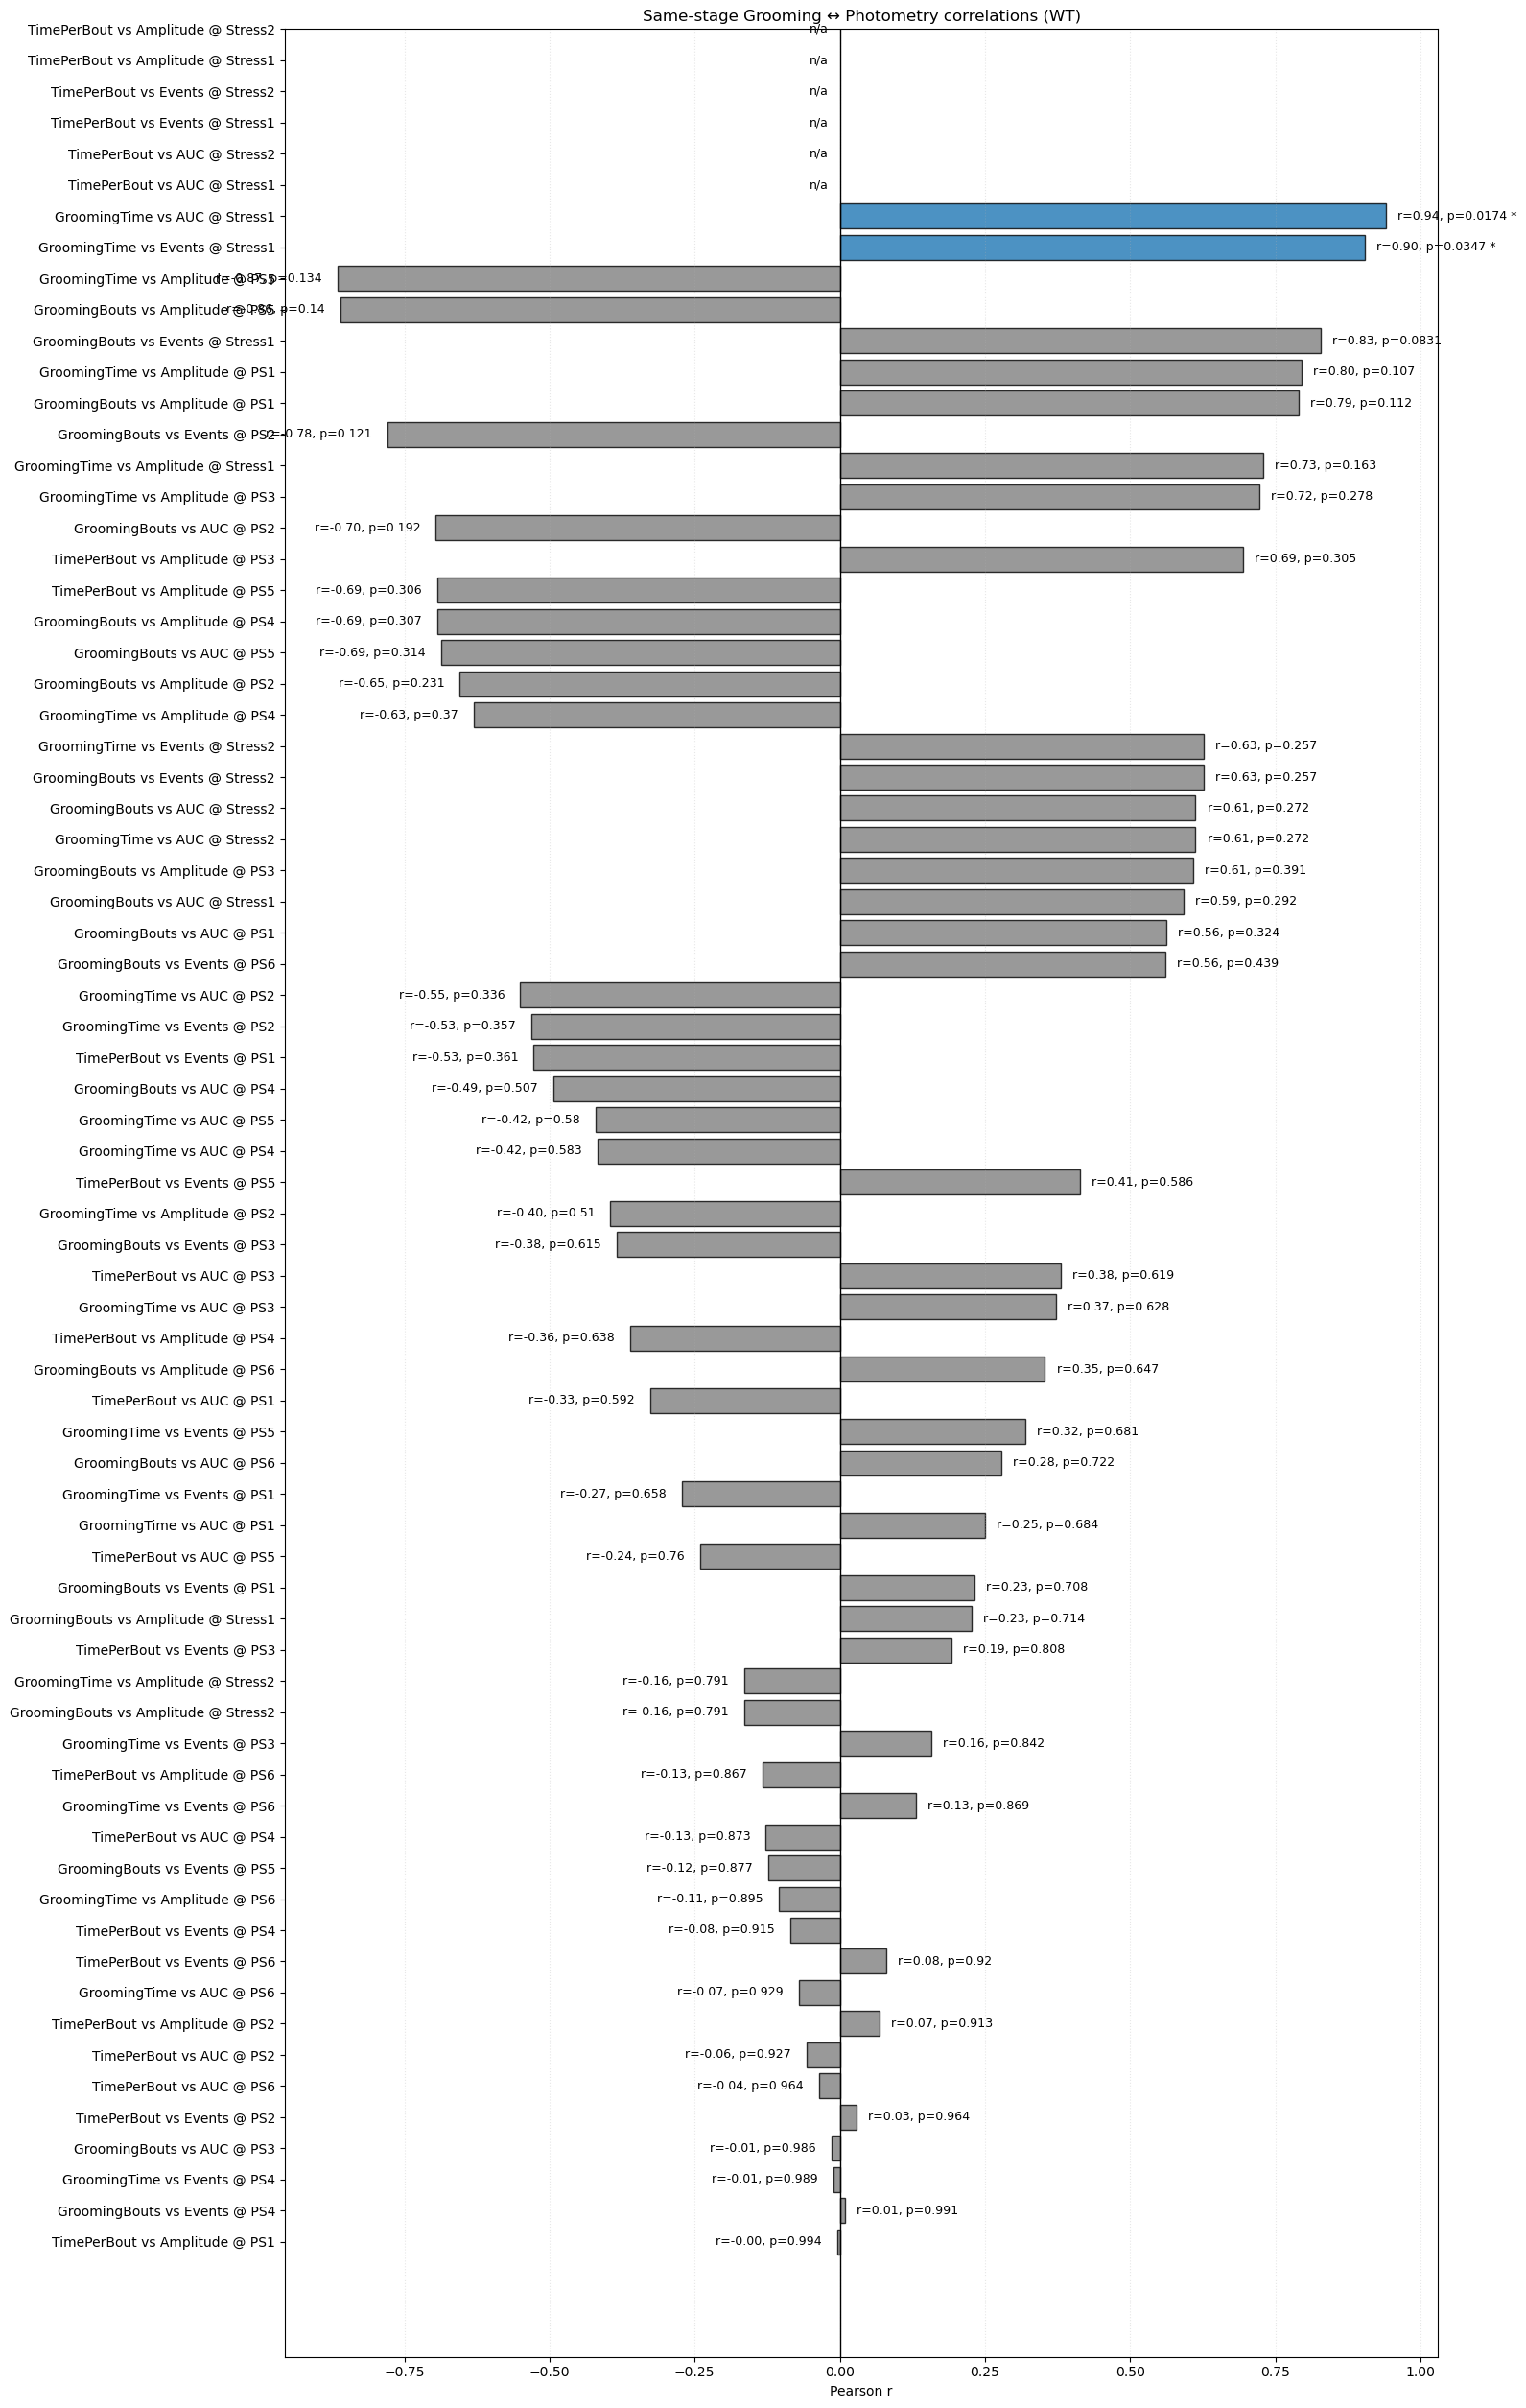

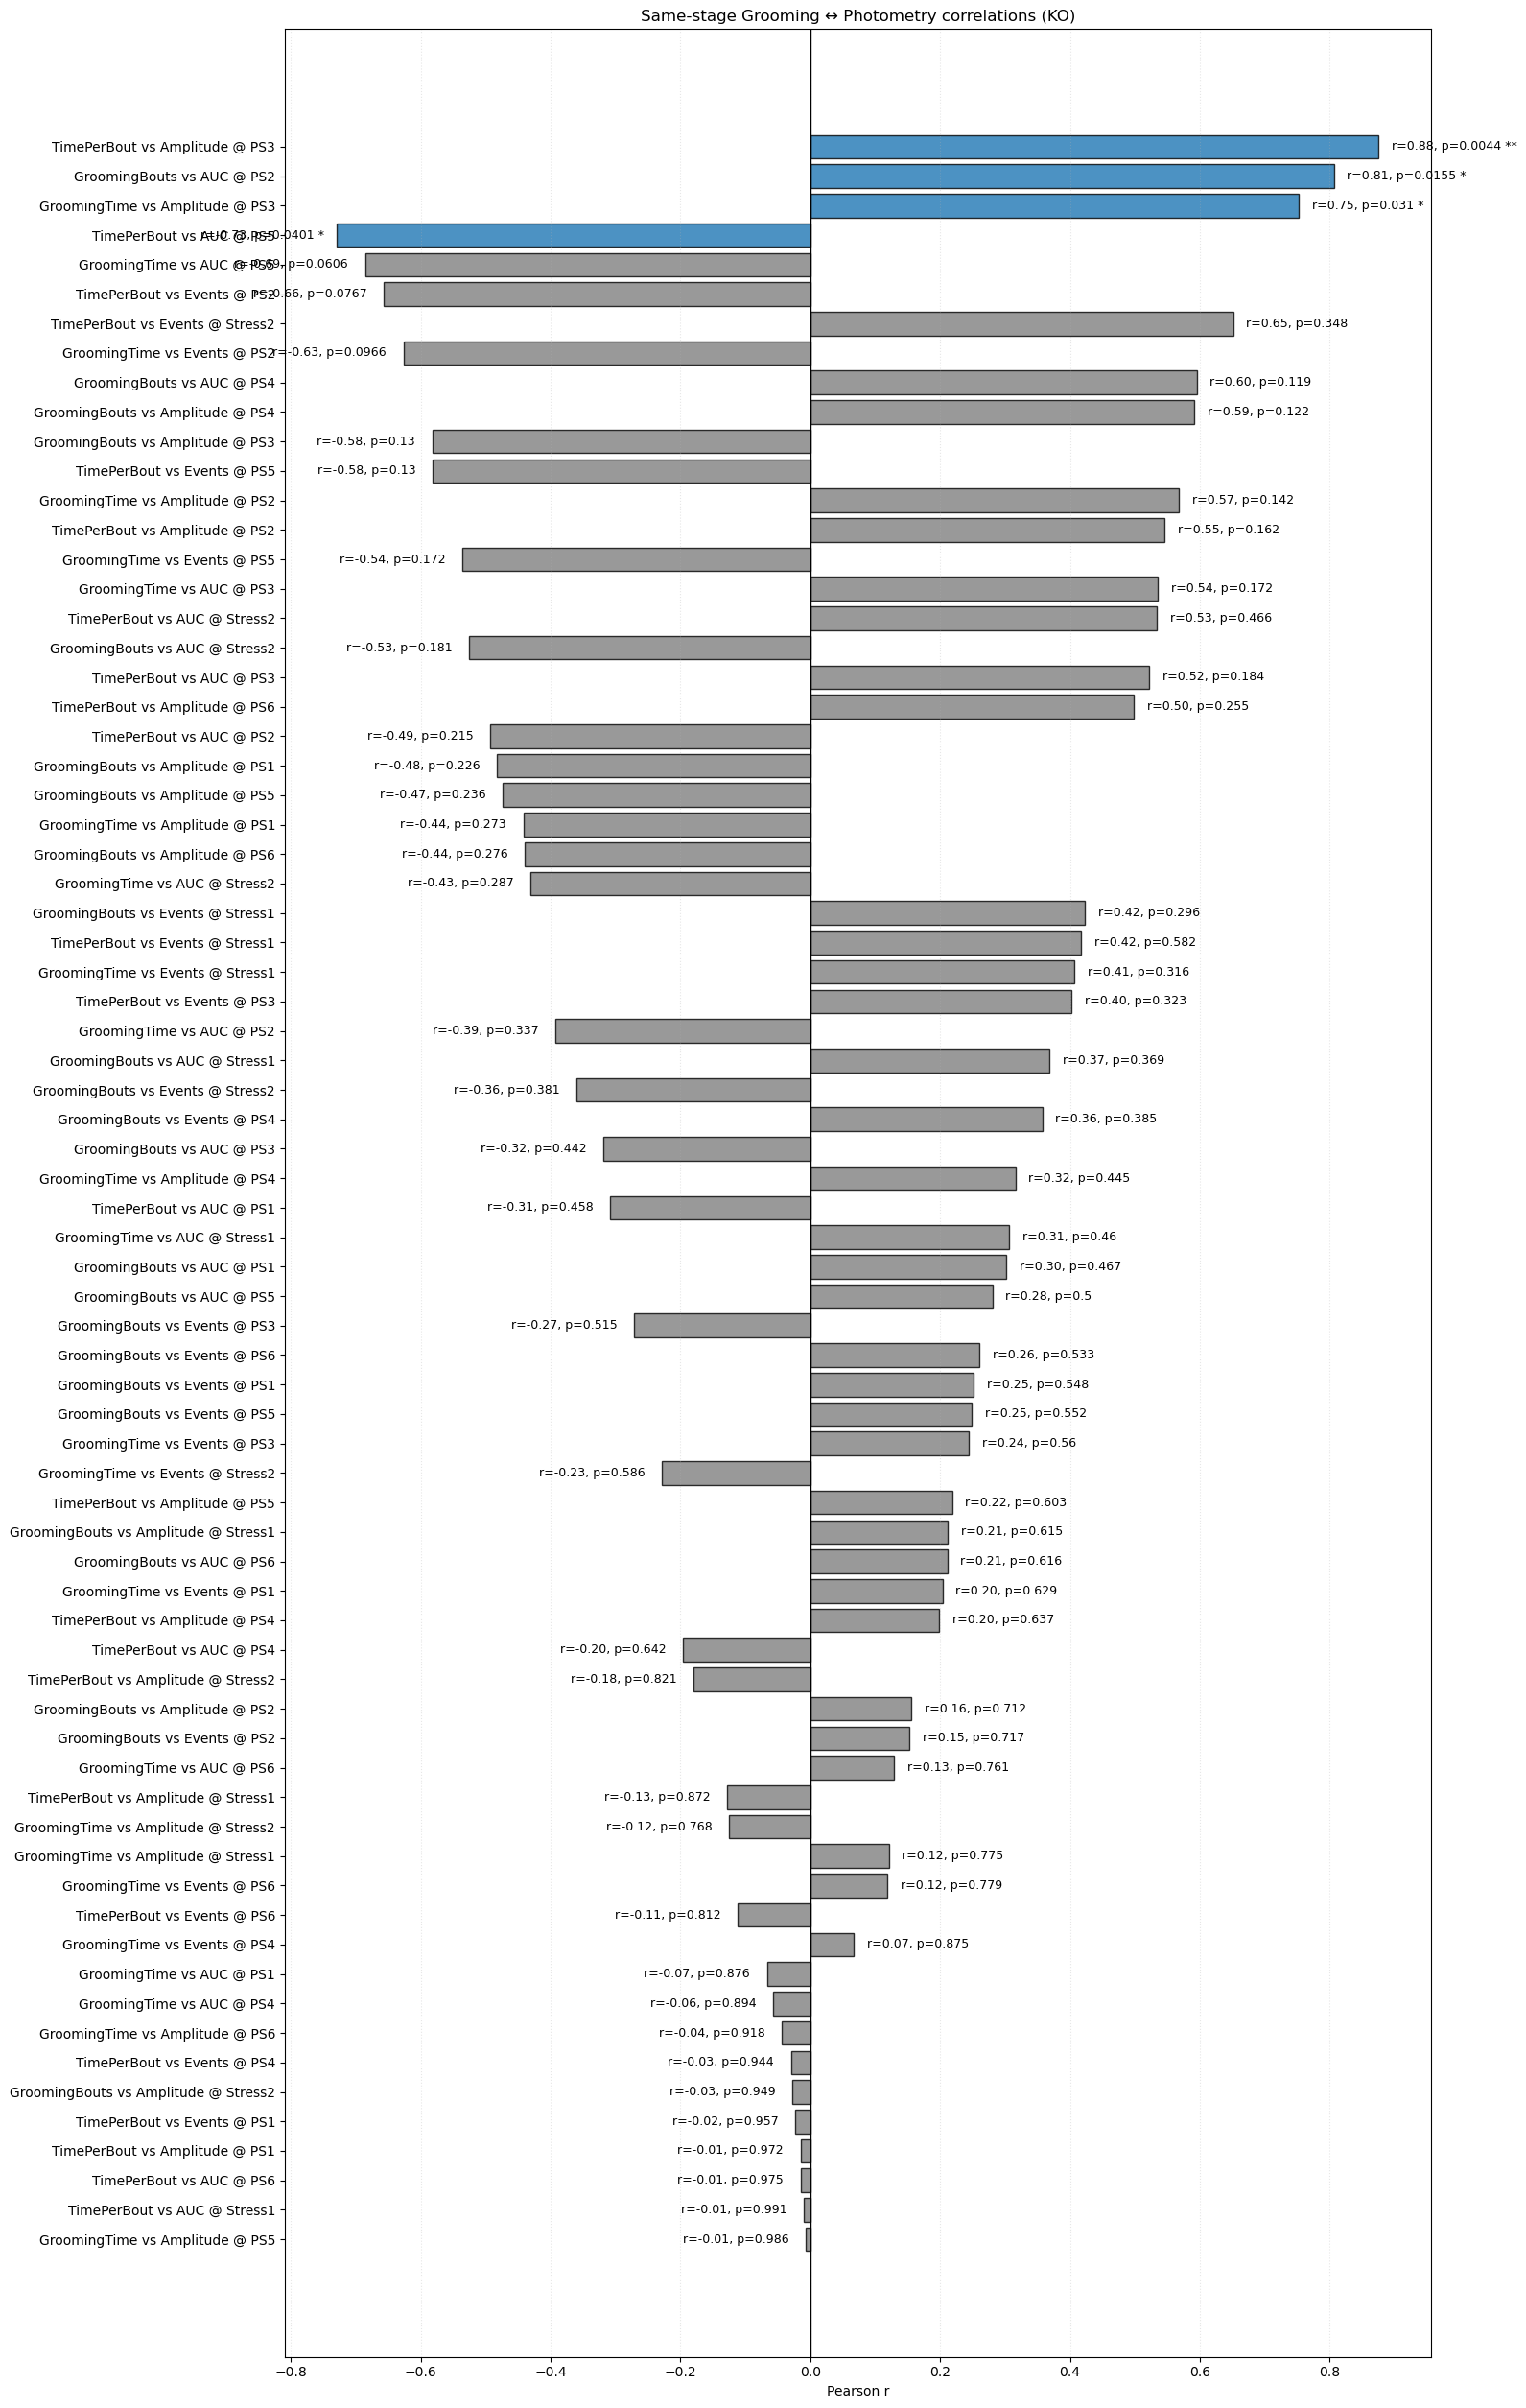

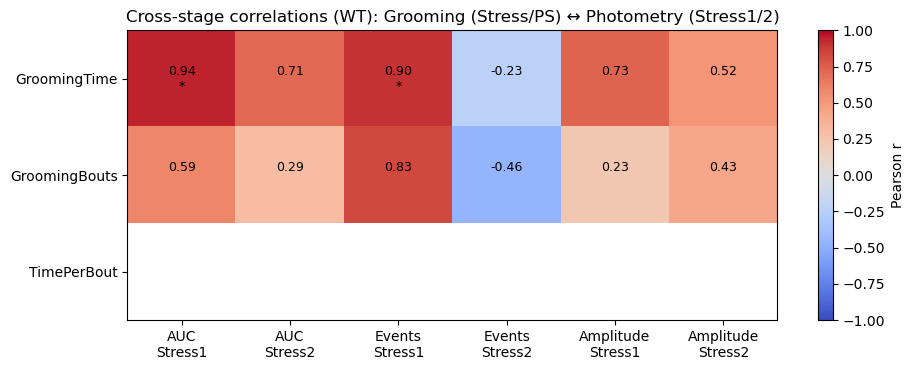

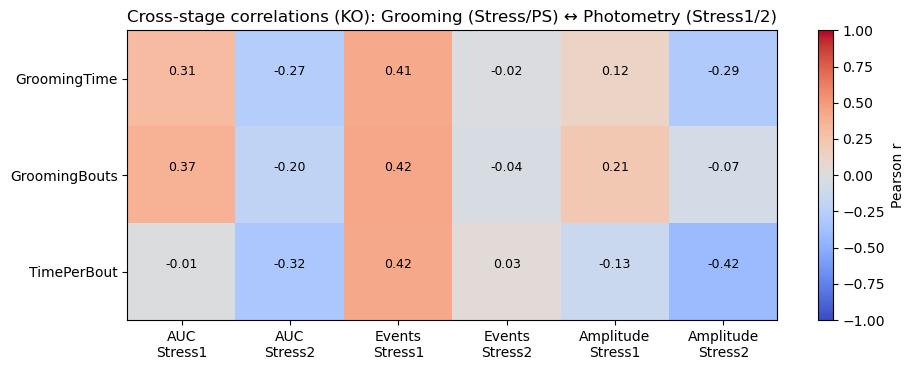

In [210]:
for geno in ["WT","KO"]:
    sub = corr_same[corr_same["Genotype"]==geno].copy()
    if sub.empty: continue
    sub["label"] = (sub["GroomingMetric"]+" vs "+sub["PhotometryMetric"]+
                    " @ "+sub["GroomingStage"])
    sub = sub.sort_values("r", key=lambda s: s.abs(), ascending=True)

    fig, ax = plt.subplots(figsize=(16,max(4,0.35*len(sub))))
    y = np.arange(len(sub))
    colors_bars = ["tab:blue" if (p<0.05) else "gray" for p in sub["p"]]
    ax.barh(y, sub["r"], color=colors_bars, edgecolor="black", alpha=0.8)
    ax.set_yticks(y, sub["label"])
    ax.set_xlabel("Pearson r")
    ax.set_title(f"Same-stage Grooming ↔ Photometry correlations ({geno})")

    for i,(r,p,sig) in enumerate(zip(sub["r"],sub["p"],sub["sig"])):
        txt=f"r={r:.2f}, p={p:.3g} {sig if sig!='ns' else ''}" if not np.isnan(r) else "n/a"
        ax.text(np.nan_to_num(r, nan=0)+(0.02 if r>=0 else -0.02), i, txt,
                va="center", ha="left" if r>=0 else "right", fontsize=9)
    ax.axvline(0,color="black",lw=1)
    ax.grid(axis="x",linestyle=":",alpha=0.3)
    plt.tight_layout()
    plt.show()

# ------- Cross-stage: heatmaps (WT/KO separately) -------
for geno in ["WT","KO"]:
    sub = corr_cross[corr_cross["Genotype"]==geno]
    if sub.empty: continue
    cols=[]
    for pm in photometry_metrics_for_corr:
        for stp in ["Stress1","Stress2"]:
            cols.append((pm,stp))
    R=np.full((len(grooming_metrics_for_corr),len(cols)),np.nan)
    Stars=np.full((len(grooming_metrics_for_corr),len(cols)),"",dtype=object)
    for i,gm in enumerate(grooming_metrics_for_corr):
        for j,(pm,stp) in enumerate(cols):
            row=sub[(sub["GroomingMetric"]==gm)&(sub["PhotometryMetric"]==pm)&(sub["PhotometryStage"]==stp)]
            if not row.empty:
                R[i,j]=row["r"].values[0]
                Stars[i,j]=row["sig"].values[0] if row["sig"].values[0]!="ns" else ""
    fig,ax=plt.subplots(figsize=(1.6*len(cols),0.6*len(grooming_metrics_for_corr)+2))
    im=ax.imshow(R,aspect="auto",cmap="coolwarm",vmin=-1,vmax=1)
    ax.set_xticks(np.arange(len(cols)),[f"{pm}\n{stp}" for (pm,stp) in cols])
    ax.set_yticks(np.arange(len(grooming_metrics_for_corr)),grooming_metrics_for_corr)
    ax.set_title(f"Cross-stage correlations ({geno}): Grooming (Stress/PS) ↔ Photometry (Stress1/2)")
    for i in range(R.shape[0]):
        for j in range(R.shape[1]):
            if not np.isnan(R[i,j]):
                ax.text(j,i,f"{R[i,j]:.2f}\n{Stars[i,j]}",ha="center",va="center",fontsize=9)
    cbar=plt.colorbar(im,ax=ax)
    cbar.set_label("Pearson r")
    plt.tight_layout()
    plt.show()